Remember to

```sh
sudo apt install ffmpeg libavcodec-extra
```

In [55]:
# # Download model checkpoints:
# import torch

# # dinov2_vits14_reg_lc = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg_lc')
# dinov2_vits14_reg_lc = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_lc')

# # Then move ckpt to dinov2/checkpoints

In [56]:

import sys
import os
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

if 'dinov2' in sys.modules:
    del sys.modules['dinov2']
    
# Get the absolute path of the project root
project_root = os.path.abspath("..")  # Adjust path if your notebook is deeper in directories

# Add project root to sys.path
sys.path.insert(0, project_root)

# sys.path.append(project_root)

    
# Now you can import dinov2
import dinov2
print("Currently using dinov2 from:", dinov2.__file__)



from dinov2.eval.setup import build_model_for_eval
from dinov2.configs import load_and_merge_config
from dinov2.utils.visualize import print_video_model_stats, load_and_preprocess_image, get_model_output, \
    two_stage_pca, compute_cosine_similarity, save_triple_image

device = "cuda"
device = torch.device(device if torch.cuda.is_available() else "cpu")
print(device)

Currently using dinov2 from: /scorpio/home/luyukuan/projects/dinov2/dinov2/__init__.py
cuda


Load dinov2 (with registers) model

In [ ]:
model_size = "b"
with_registers = "_reg4" # "_reg4"
# Use `dinov2_vits14_pretrain`
conf = load_and_merge_config(f'eval/vit{model_size}14{with_registers}_pretrain')
model = build_model_for_eval(conf, f'../dinov2/checkpoints/dinov2_vit{model_size}14{with_registers}_pretrain.pth')
# model = build_model_for_eval(conf, f'../dinov2/checkpoints/dinov2_vit{model_size}14_pretrain.pth')

THRESHOLD = 0.2


In [ ]:
def main(img1_path, img2_path, img1_vis_path, img2_vis_path, model, device, threshold=0.6):
    frame_num = os.path.basename(img1_path).split('_')[1].split('.')[0]
    
    # Load and preprocess images. Make sure each image is of size 448x448
    img1_prenorm, img1_normalized = load_and_preprocess_image(img1_path, target_size=448*1, patch_size=model.patch_size)
    img2_prenorm, img2_normalized = load_and_preprocess_image(img2_path, target_size=448*1, patch_size=model.patch_size)
    
    # Move images to device
    img1 = img1_normalized.unsqueeze(0).to(device)
    img2 = img2_normalized.unsqueeze(0).to(device)
    
    B, C, H, W, patch_size, embedding_dim, patch_num = print_video_model_stats(img1, model)
    
    # Get cls token embedding and patch token embeddings
    cls_token_emb1, patch_token_embs1 = get_model_output(model, img1)
    cls_token_emb2, patch_token_embs2 = get_model_output(model, img2)
    
     # Calculate similarity
    similarity = compute_cosine_similarity(cls_token_emb1, cls_token_emb2)
    normalized_distance = (1 - similarity) / 2
    
    # Get PCA visualization of the representation space
    reduced_embeds1, reduced_fg_embeds1, nums_of_fg_patches1, masks1 = two_stage_pca(patch_token_embs1, threshold=threshold)
    reduced_embeds2, reduced_fg_embeds2, nums_of_fg_patches2, masks2 = two_stage_pca(patch_token_embs2, threshold=threshold)
    
    save_triple_image(img1_prenorm, reduced_embeds1, reduced_fg_embeds1, nums_of_fg_patches1, masks1, patch_num, patch_size, output_path=img1_vis_path)
    save_triple_image(img2_prenorm, reduced_embeds2, reduced_fg_embeds2, nums_of_fg_patches2, masks2, patch_num, patch_size, output_path=img2_vis_path)
    
    result = {
        "frame_num": frame_num,
        "img1": {
            "cls_token_emb": cls_token_emb1,
            "patch_token_embs": patch_token_embs1,
            "reduced_embeds": reduced_embeds1,
            "reduced_fg_embeds": reduced_fg_embeds1,
            "nums_of_fg_patches": nums_of_fg_patches1,
            "masks": masks1
        },
        "img2": {
            "cls_token_emb": cls_token_emb2,
            "patch_token_embs": patch_token_embs2,
            "reduced_embeds": reduced_embeds2,
            "reduced_fg_embeds": reduced_fg_embeds2,
            "nums_of_fg_patches": nums_of_fg_patches2,
            "masks": masks2
        },
        "distance": normalized_distance,
        "patch_size": patch_size,
        "patch_num": patch_num,
    }
    return result

    
def get_image_pairs(base_dir):
    """Extract all matching image pairs from original and covered directories"""
    # Get all frame_X.png files from both directories
    original_dir = os.path.join(base_dir, 'original')
    covered_dir = os.path.join(base_dir, 'covered')
    
    # List all matching files using a list comprehension
    frame_files = [f for f in os.listdir(original_dir) if f.startswith('frame_') and (f.endswith('.png') or f.endswith('.jpg'))]
    
    # Create pairs of paths
    pairs = [(os.path.join(original_dir, f), os.path.join(covered_dir, f)) 
             for f in frame_files if os.path.exists(os.path.join(covered_dir, f))]
    
    return pairs

def plot(img1_path, img2_path, distance, output_path=None):
    """Plot a pair of images with their distance"""
    # Create figure with stacked images (one above the other)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))
    
    # Load and display images
    img1 = Image.open(img1_path)
    img2 = Image.open(img2_path)
    
    ax1.imshow(img1)
    ax1.set_title("Original")
    ax1.axis('off')
    
    ax2.imshow(img2)
    ax2.set_title("Covered")
    ax2.axis('off')
    
    plt.suptitle(f"Distance: {distance*100:.2f}%", fontsize=16)
    plt.tight_layout()
    
    # Save or display the figure
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.close()
    else:
        plt.show()


Found 5 image pairs
Input tensor shape: Batch=1, Channels=3, Height=448, Width=448
Patch size: 14
Embedding dimension: 768
Number of patches of each image: 1024
Num of foreground patches of image 0: 495
Total num of foreground patches: 495
Explained variance ratio by PCA components: [0.2976248  0.18268432 0.13103077]
Num of foreground patches of image 0: 484
Total num of foreground patches: 484
Explained variance ratio by PCA components: [0.30691788 0.18024871 0.12656385]


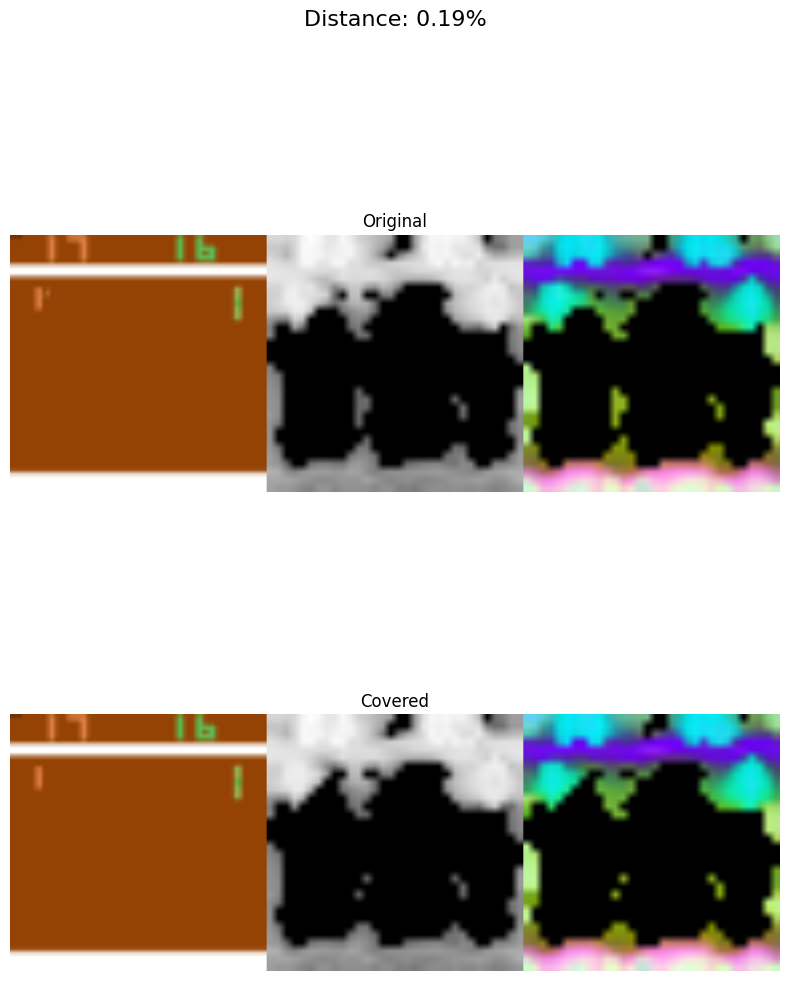

Input tensor shape: Batch=1, Channels=3, Height=448, Width=448
Patch size: 14
Embedding dimension: 768
Number of patches of each image: 1024
Num of foreground patches of image 0: 549
Total num of foreground patches: 549
Explained variance ratio by PCA components: [0.25689048 0.18454248 0.13944036]
Num of foreground patches of image 0: 552
Total num of foreground patches: 552
Explained variance ratio by PCA components: [0.25820857 0.17411174 0.14098419]


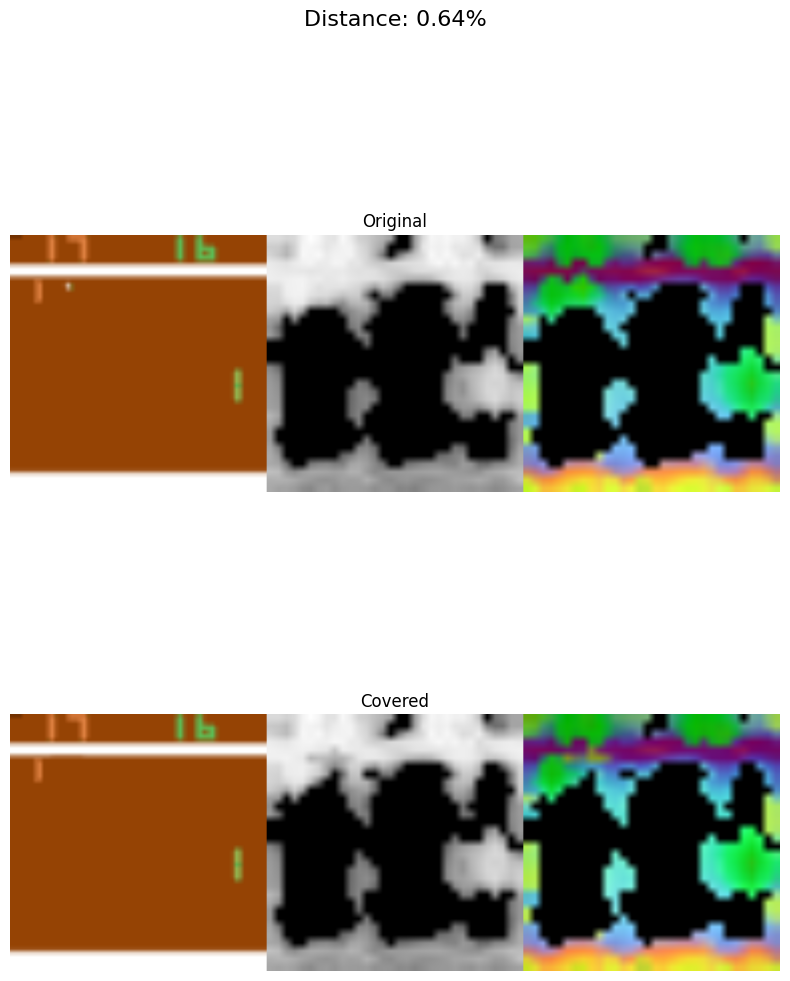

Input tensor shape: Batch=1, Channels=3, Height=448, Width=448
Patch size: 14
Embedding dimension: 768
Number of patches of each image: 1024
Num of foreground patches of image 0: 531
Total num of foreground patches: 531
Explained variance ratio by PCA components: [0.26208976 0.1780653  0.14736147]
Num of foreground patches of image 0: 544
Total num of foreground patches: 544
Explained variance ratio by PCA components: [0.2574804  0.17169437 0.15143941]


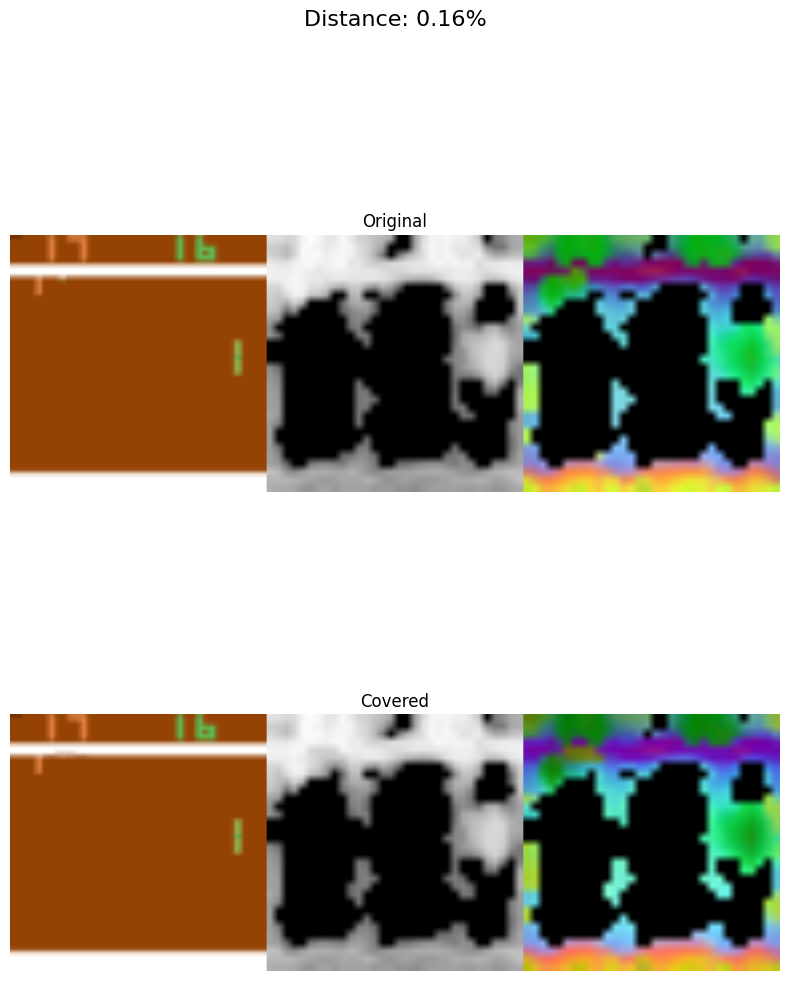

Input tensor shape: Batch=1, Channels=3, Height=448, Width=448
Patch size: 14
Embedding dimension: 768
Number of patches of each image: 1024
Num of foreground patches of image 0: 517
Total num of foreground patches: 517
Explained variance ratio by PCA components: [0.2875856  0.18107823 0.1329418 ]
Num of foreground patches of image 0: 510
Total num of foreground patches: 510
Explained variance ratio by PCA components: [0.28773716 0.17652635 0.13285086]


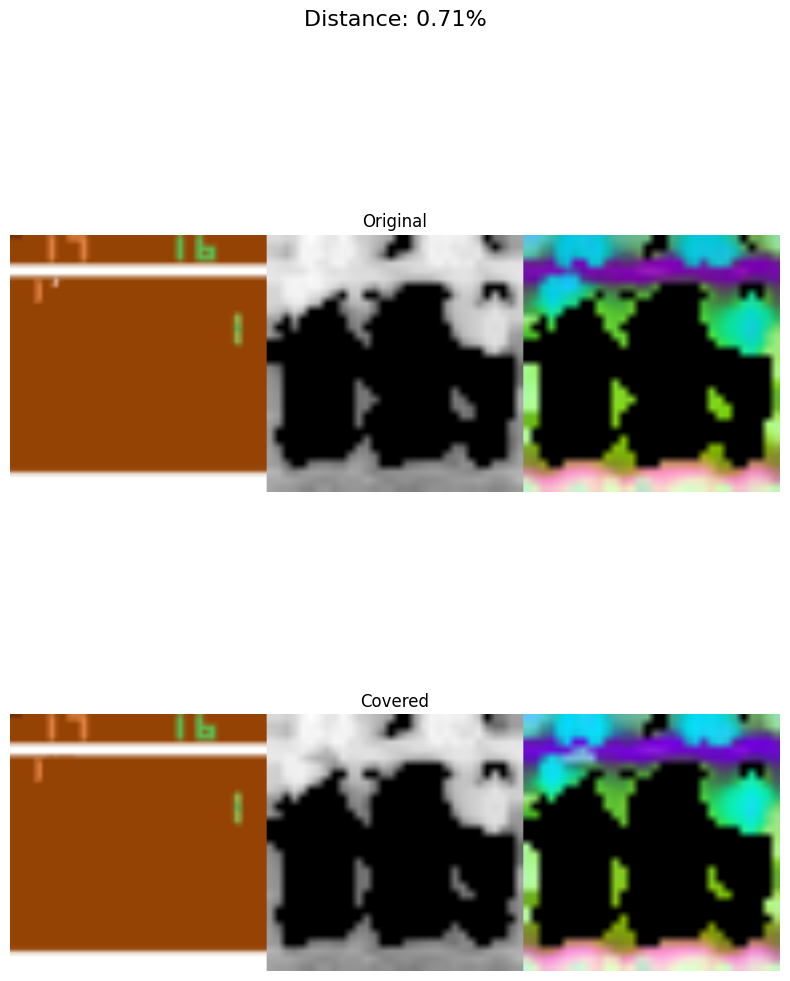

Input tensor shape: Batch=1, Channels=3, Height=448, Width=448
Patch size: 14
Embedding dimension: 768
Number of patches of each image: 1024
Num of foreground patches of image 0: 557
Total num of foreground patches: 557
Explained variance ratio by PCA components: [0.2514092  0.19070724 0.13912572]
Num of foreground patches of image 0: 547
Total num of foreground patches: 547
Explained variance ratio by PCA components: [0.25855055 0.1900137  0.14705335]


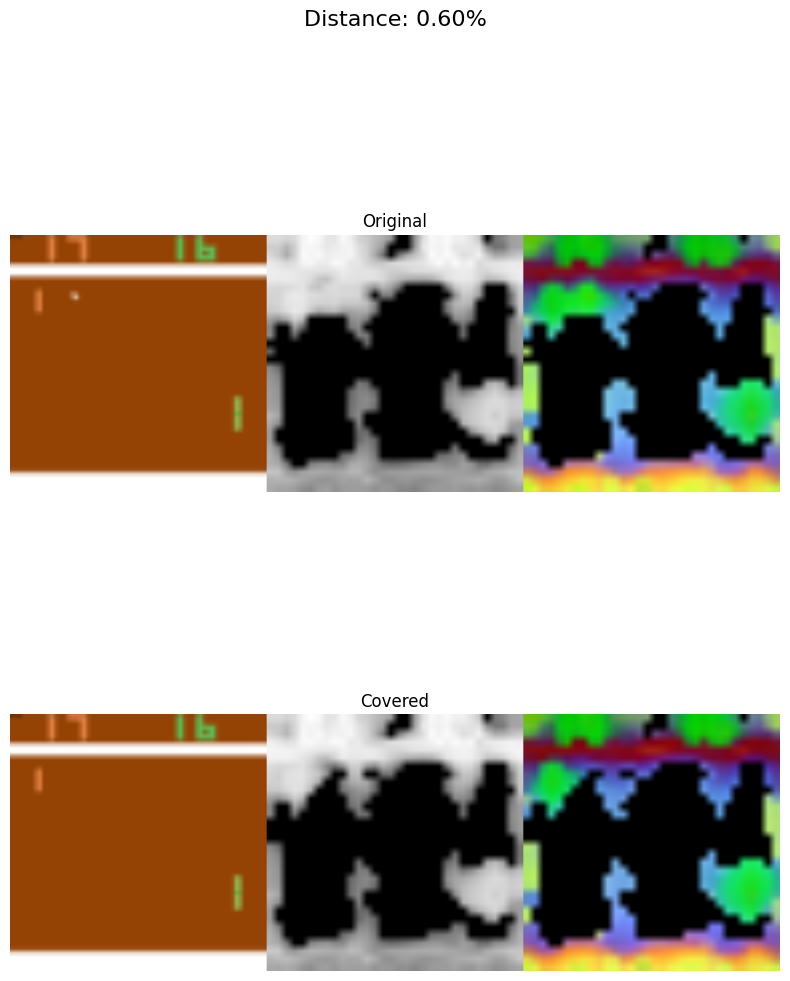

Average distance: 0.46%
Min distance: 0.16%
Max distance: 0.71%


In [ ]:
base_dir = "./data/pong"
visualization_dir = "./data/pong_visualization"
image_pairs = get_image_pairs(base_dir)
print(f"Found {len(image_pairs)} image pairs")


# Get all image pairs and create directories for visualization
visualization_dir1 = os.path.join(visualization_dir, 'original')
visualization_dir2 = os.path.join(visualization_dir, 'covered')
os.makedirs(visualization_dir1, exist_ok=True)
os.makedirs(visualization_dir2, exist_ok=True)


# Store results
frame_distance_list = []

# Process each pair
for original_path, covered_path in image_pairs:
    original_triple_img_path = os.path.join(visualization_dir1, os.path.basename(original_path.replace('.png', '_pca.png')))
    covered_triple_img_path = os.path.join(visualization_dir2, os.path.basename(covered_path.replace('.png', '_pca.png')))
    
    result = main(original_path, covered_path, original_triple_img_path, covered_triple_img_path, model, device, threshold=THRESHOLD)
    frame_distance_list.append((result['frame_num'], result['distance']))
    
    # Plot the image pair
    plot(original_triple_img_path, covered_triple_img_path, result['distance'])

# Plot distance across all frames
frame_numbers, similarities = zip(*sorted(frame_distance_list))
plt.figure(figsize=(12, 6))
plt.plot(frame_numbers, [s*100 for s in similarities], 'o-')
plt.title('Frame Distances')
plt.xlabel('Frame Number')
plt.ylabel('Distance (%)')
plt.grid(True)
plt.savefig(os.path.join(visualization_dir, "distance_summary.png"), dpi=150, bbox_inches='tight')
plt.close()

# Print summary statistics
avg_distance = sum(s for _, s in frame_distance_list) / len(frame_distance_list)
print(f"Average distance: {avg_distance*100:.2f}%")
print(f"Min distance: {min(s for _, s in frame_distance_list)*100:.2f}%")
print(f"Max distance: {max(s for _, s in frame_distance_list)*100:.2f}%")

1. 0.9993
2. 0.9975
3. 0.9991
4. 0.9968
5. 0.9946

